In [1]:
# Step 1: Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
import joblib
import shap
import matplotlib.pyplot as plt

C:\Users\talib\churn-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 2: Load dataset
df = pd.read_csv("C:/Users/talib/churn-project/data/Telco-Customer-Churn.csv")

In [3]:
# Cleaning same as EDA
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
df = df.drop(columns=['customerID'])

In [4]:
# Binary encode Yes/No columns
binary_cols = ['Partner','Dependents','PhoneService','PaperlessBilling']
for c in binary_cols:
    df[c] = df[c].map({'Yes':1,'No':0})

In [5]:
# Tenure groups
df['tenure_group'] = pd.cut(df['tenure'], bins=[0,12,24,48,60,100],
                            labels=['0-12','13-24','25-48','49-60','60+'])

In [6]:
# Step 3: X and y
X = df.drop(columns=['Churn'])
y = df['Churn'].map({'Yes':1,'No':0})


In [7]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
# Step 4: Identify columns
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()

In [10]:
# Preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])

In [11]:
# Step 5: Baseline model - Logistic Regression
pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:,1]

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_prob))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407

ROC AUC: 0.8344743776239705


In [12]:
# Step 6: Stronger model - RandomForest with RandomizedSearchCV
pipe.set_params(clf=RandomForestClassifier(random_state=42))
param_dist = {
    'clf__n_estimators':[100,200,500],
    'clf__max_depth':[None,10,20,30],
    'clf__min_samples_split':[2,5,10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(pipe, param_dist, n_iter=12, scoring='f1', cv=cv, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
best = search.best_estimator_

# Step 7: Evaluate
y_prob = best.predict_proba(X_test)[:,1]
thresholds = np.linspace(0.01,0.99,99)
f1s = [f1_score(y_test,(y_prob>t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
print("Best threshold by F1:", best_t)

y_pred_thresh = (y_prob>best_t).astype(int)
print(classification_report(y_test, y_pred_thresh))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best threshold by F1: 0.4
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1033
           1       0.52      0.79      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407

ROC AUC: 0.8280370759586064
Confusion Matrix:
 [[759 274]
 [ 78 296]]


In [13]:
# Step 8: Feature Importance
ohe = best.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_ohe_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_ohe_names

importances = best.named_steps['clf'].feature_importances_
imp_df = pd.DataFrame({'feature':feature_names,'importance':importances}).sort_values('importance', ascending=False)
print("\nTop 15 Important Features:")
display(imp_df.head(15))


Top 15 Important Features:


,feature,importance
34,Contract_Month-to-month,0.120593
39,PaymentMethod_Electronic check,0.080779
3,tenure,0.080450
16,OnlineSecurity_No,0.068510
25,TechSupport_No,0.055237
36,Contract_Two year,0.051631
7,TotalCharges,0.051144
6,MonthlyCharges,0.048380
41,tenure_group_0-12,0.040785
14,InternetService_Fiber optic,0.039731


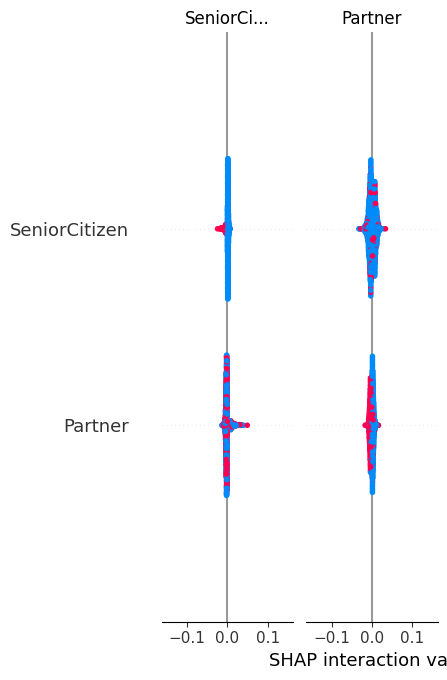

In [14]:
# Step 9: SHAP plots
clf = best.named_steps['clf']
X_test_trans = best.named_steps['preprocessor'].transform(X_test)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test_trans)
shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)

In [15]:
# Step 10: Save pipeline
import os
os.makedirs('../models', exist_ok=True)
joblib.dump(best,'../models/churn_pipeline_v1.joblib')

['../models/churn_pipeline_v1.joblib']